# ML for science - Unfold
## Baudoin von Sury - Pierre Vuillecard - Hugo Birch

## This notebook present the different predictions of CL using Neural Networks maching learning method.

We used the sklearn python librairy (https://keras.io) to perform different regression on our data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras.activations import elu
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import probplot

#from neural_networks import *
from NN_mean import *
from helpers import *

np.random.seed(123)

Using TensorFlow backend.


In [2]:
# Definition of the path of the data
path = os.getcwd()
path = path + '/ml_data/complete/complete/'

In [3]:
# Load the data (CL and kinematic alphas for the N_EXP experiments)
N_EXP = 4100
CL = load_data(path,N_EXP, cl = True)

# Shuffle the data
random_permuted_indices = np.random.permutation(N_EXP)
CL = CL[random_permuted_indices,:,:]

# Prediction of average CL from kinematic alpha
The aim of this part is to find the best neural network to predict CL from kinematic alphas. We used simple neural network structure from keras library and tunned it with the following techniques :
- Adding hidden layers.
- Playing with the hidden layers sizes.
- Trying different activation functions.
- Increasing the number of epoch.
- Choosing a wise early stopping criteria.
We analyse the performance of each different models through the mse and a probability plot.

In [4]:
# Compute the mean of each CL
CL_mean = np.mean(CL[:,1,:] , axis =1).reshape((N_EXP,1))

# Split the data
num_train = int(0.8*N_EXP)
X_train = CL[:num_train,0,:]
X_test = CL[num_train:,0,:]
Y_train = CL_mean[:num_train]
Y_test = CL_mean[num_train:]

In [5]:
def model_training(model,X_train,X_test,Y_train,Y_test, patience_ = 50 , plot=True ):
    """Train the different models and return the MSE values"""
    early_stop = EarlyStopping(monitor ="val_loss", patience = patience_ , verbose = 1)
    history = model.fit(X_train, Y_train, validation_split=0.2, epochs=2000 ,callbacks=[early_stop] , verbose=0)
    train_mse = model.evaluate(X_train, Y_train, verbose=0)
    test_mse = model.evaluate(X_test, Y_test, verbose=0)
    print('MSE Train: %.3f | MSE Test: %.3f' % (train_mse, test_mse))
    if plot :
        # plot loss during training
        plt.title('Loss / Mean Squared Error')
        plt.plot(history.history['loss'], label='train')
        plt.plot(history.history['val_loss'], label='test')
        plt.legend()
        plt.show()
    return train_mse,test_mse

## Base Line model
We first start by creating a base-line model in order to have a reference.

In [6]:
def build_model_base_line(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(1 ,input_shape=(200,)))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [7]:
model_base = build_model_base_line()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 201       
Total params: 201
Trainable params: 201
Non-trainable params: 0
_________________________________________________________________
None


Epoch 01833: early stopping
MSE Train: 0.354 | MSE Test: 0.352


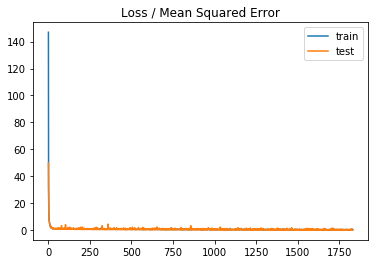

(0.3541770010459714, 0.35231056227916624)

In [8]:
patience_ = 50
model_training(model_base,X_train, X_test , Y_train, Y_test, patience_ )

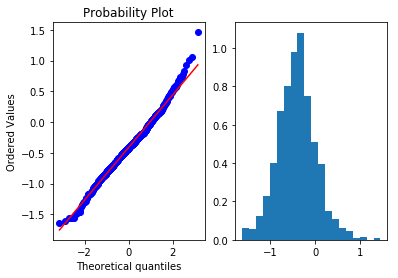

In [9]:
plot_stat(model_base , X_test , Y_test)

###### Comments : Really great QQplot
#### Next Step : Let's try to add a layer

In [10]:
def build_model_1(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128 ,input_shape=(200,),activation ='elu'))
    model.add(Dense(1))
    if summary:
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [11]:
model_1 = build_model_1()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 25,857
Trainable params: 25,857
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00310: early stopping
MSE Train: 0.075 | MSE Test: 0.079


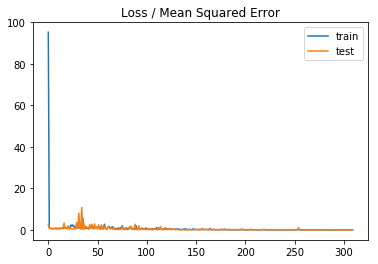

(0.07527590884668071, 0.0787697632865208)

In [12]:
model_training(model_1,X_train, X_test , Y_train, Y_test )

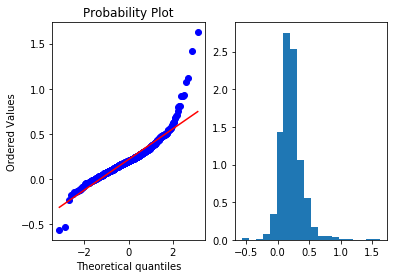

In [13]:
plot_stat(model_1, X_test , Y_test)

###### Comments : MSE is way better !
#### Next Step : add again a layer (64)

In [14]:
def build_model_2(summary = True):
    
    #architecture
    model = Sequential()
    model.add(Dense(128,input_shape=(200,),activation ='elu'))
    model.add(Dense(64,activation ='elu'))
    model.add(Dense(1))
    if summary :
        print(model.summary())
    
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [15]:
model_2 = build_model_2()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               25728     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
None


Epoch 00306: early stopping
MSE Train: 0.089 | MSE Test: 0.085


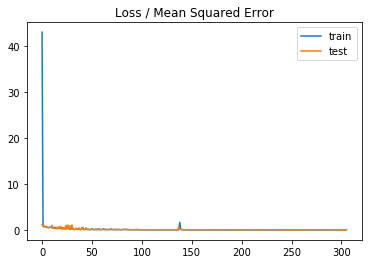

(0.08893074978415559, 0.08535886016197321)

In [16]:
model_training(model_2 ,X_train, X_test , Y_train, Y_test )

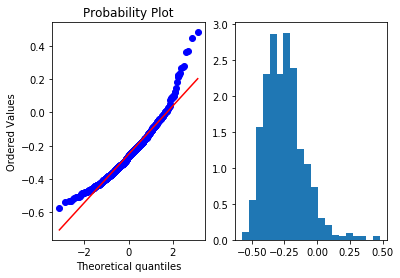

In [17]:
plot_stat(model_2, X_test , Y_test)

###### Comments : The MSE is not as great as the model 1 
#### Next Step : Cross validation

## We are now going to do cross validation for the base line model and the best model (2).

In [19]:
k_fold = 4
train_mse,test_mse = cross_validation(build_model_base_line, CL,k_fold )
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

Epoch 00568: early stopping
MSE Train: 0.848 | MSE Test: 0.807
MSE Train: 0.364 | MSE Test: 0.357
Epoch 01187: early stopping
MSE Train: 0.499 | MSE Test: 0.531
Epoch 01861: early stopping
MSE Train: 0.539 | MSE Test: 0.516
Cross validation results : MSE train = 0.5624387321445515 | MSE test = 0.5527004687317716


Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_78 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00005: early stopping
Train: 0.828, Test: 0.874


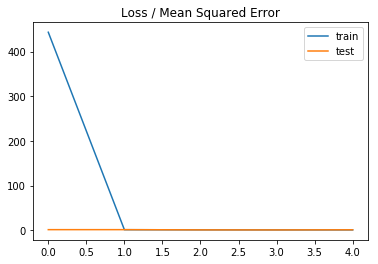

Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_80 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_81 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00003: early stopping
Train: 0.604, Test: 0.572


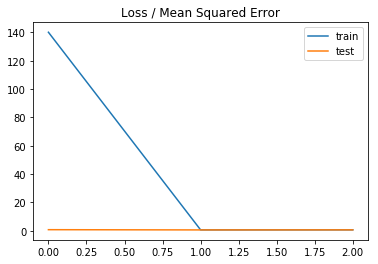

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_84 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_85 (Dense)             (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00006: early stopping
Train: 0.538, Test: 0.626


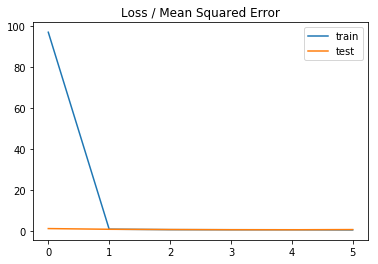

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_87 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 65        
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 00005: early stopping
Train: 1.163, Test: 1.110


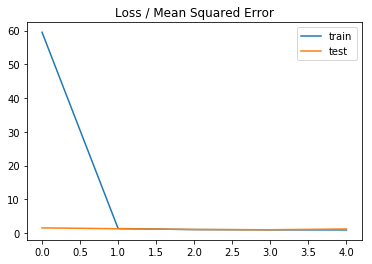

In [94]:
k_fold = 4
train_mse,test_mse = cross_validation(build_model_2, CL, k_fold)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

###### Comments : 

## Now we are going to try to rescale the input in [0,1]

In [20]:
# Scaling the data
def scale( X,min_ , max_ ):
    return (X - min_)/(max_-min_) 

min_ = -90
max_ = 90 
num_train    = int(0.8*N_EXP)
X_train_insc = scale(CL[:num_train,0,:],min_ , max_ )
X_test_insc  = scale(CL[num_train:,0, :],min_ , max_ )
Y_train_insc = CL_mean[:num_train]
Y_test_insc  = CL_mean[num_train:]

## Then let's apply the rescale to Model the baseline model

In [21]:
def build_baseline_model_rs():
    model = Sequential()
    model.add(Dense(1 , input_shape=(200,) ))
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [22]:
model_base_line = build_baseline_model_rs()

Epoch 00990: early stopping
MSE Train: 0.081 | MSE Test: 0.078


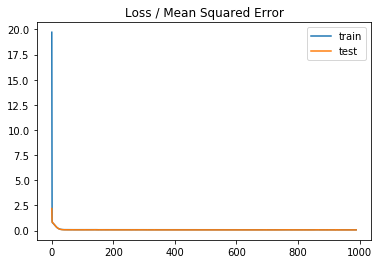

(0.08132340606392884, 0.07798117232031938)

In [23]:
model_training(model_base_line,X_train_insc ,X_test_insc ,Y_train_insc ,Y_test_insc )

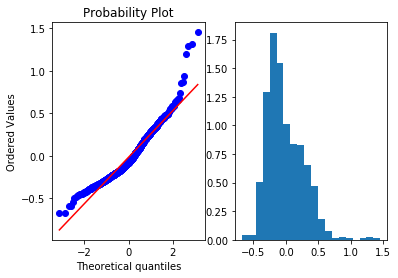

In [24]:
plot_stat(model_base_line,X_test_insc , Y_test_insc)

###### Comments : Results is way better already with scaled inputs
## Then let's apply the rescale to Model 1

In [25]:
def model_1_rs():
    model = Sequential()
    model.add(Dense(128 , input_shape=(200,),activation = 'tanh' ))
    model.add(Dense(1))
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

In [26]:
model_1 = model_1_rs()

Epoch 00346: early stopping
MSE Train: 0.005 | MSE Test: 0.006


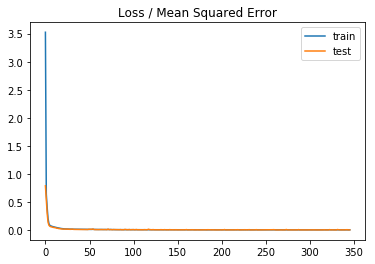

(0.005421270132519123, 0.005901697798200497)

In [27]:
model_training(model_1,X_train_insc ,X_test_insc ,Y_train_insc ,Y_test_insc )

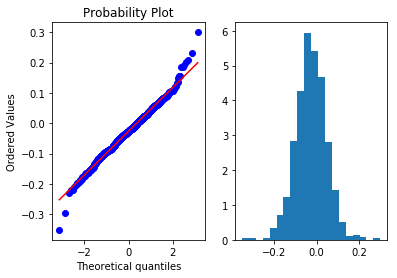

In [28]:
plot_stat(model_1,X_test_insc , Y_test_insc)

###### Comments :  MSE decrease and the QQplot looks amazing
## Then let's apply the rescale to Model 1

In [29]:
def model_2_rs():
    model = Sequential()
    model.add(Dense(128 , input_shape=(200,),activation = 'tanh' ))
    model.add(Dense(60, activation ='tanh'))
    model.add(Dense(1,activation ='linear'))
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model


In [30]:
model_2 = model_2_rs()

Epoch 00202: early stopping
MSE Train: 0.004 | MSE Test: 0.005


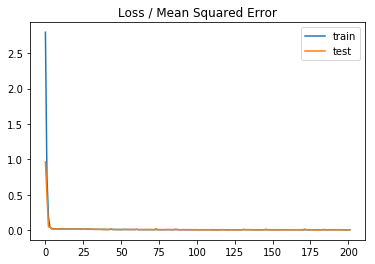

(0.004160438102056704, 0.00506791029488895)

In [31]:
model_training(model_2,X_train_insc ,X_test_insc ,Y_train_insc ,Y_test_insc )

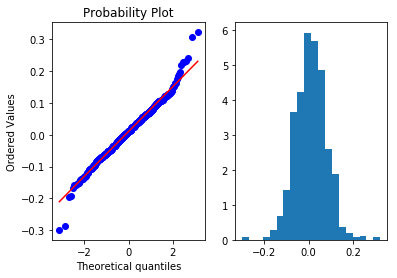

In [32]:
plot_stat(model_2,X_test_insc , Y_test_insc)

###### Comments : the decrease slightly
## Then let's apply the rescale to Model 3

In [33]:
def model_3_rs():
    model = Sequential()
    model.add(Dense(128 , input_shape=(200,),activation = 'sigmoid' ))
    model.add(Dense(60, activation ='sigmoid'))
    model.add(Dense(1))
    #optimiser 
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model


In [34]:
model_3 = model_3_rs()

Epoch 00405: early stopping
MSE Train: 0.005 | MSE Test: 0.005


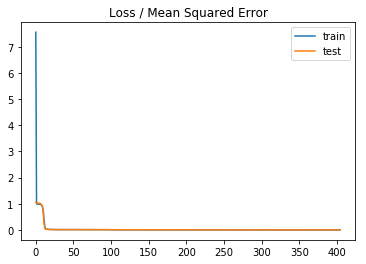

(0.004518326959095714, 0.00500249754546619)

In [35]:
model_training(model_3, X_train_insc ,X_test_insc ,Y_train_insc ,Y_test_insc )

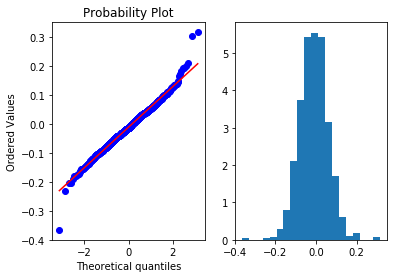

In [36]:
plot_stat(model_3, X_test_insc , Y_test_insc)

 ### Cross validation on the base line model and the best model (2)

In [39]:
k_fold = 4
train_mse,test_mse =cross_validation_sc(build_baseline_model_rs, CL,k_fold)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")

Epoch 01758: early stopping
MSE Train: 0.083 | MSE Test: 0.070
MSE Train: 0.079 | MSE Test: 0.091
MSE Train: 0.077 | MSE Test: 0.086
Epoch 01317: early stopping
MSE Train: 0.083 | MSE Test: 0.077
Cross validation results : MSE train = 0.08007427585500529 | MSE test = 0.08116338812697839


Epoch 00008: early stopping
Train: 0.020, Test: 0.016


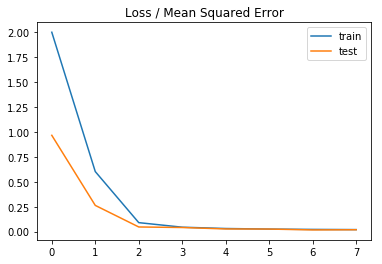

Epoch 00008: early stopping
Train: 0.018, Test: 0.022


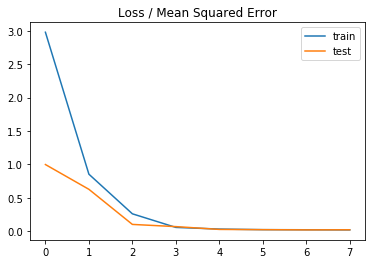

Epoch 00007: early stopping
Train: 0.022, Test: 0.024


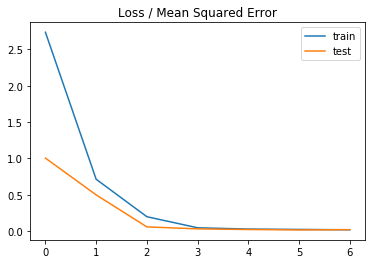

Epoch 00009: early stopping
Train: 0.018, Test: 0.019


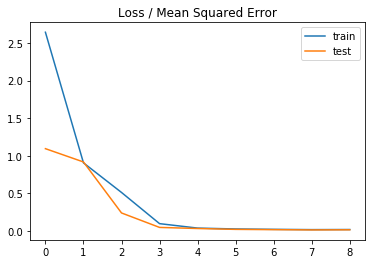

In [99]:
k_fold = 4
train_mse,test_mse =cross_validation_sc(model_2_rs, CL,k_fold)
print(f"Cross validation results : MSE train = {train_mse} | MSE test = {test_mse}")